# Тематическая модель [Постнауки](http://postnauka.ru)
## Peer Review (optional)

В этом задании мы применим аппарат тематического моделирования к коллекции текстовых записей видеолекций, скачанных с сайта Постнаука. Мы будем визуализировать модель и создавать прототип тематического навигатора по коллекции. В коллекции 1728 документов, размер словаря - 38467 слов. Слова лемматизированы, то есть приведены к начальной форме, с помощью программы [mystem](https://tech.yandex.ru/mystem/), коллекция сохранена в [формате vowpal wabbit](http://docs.bigartm.org/en/latest/formats.html). В каждой строке до первой черты записана информация о документе (ссылка на страницу с лекцией), после первой черты следует описание документа. Используются две модальности - текстовая ("text") и модальность авторов ("author"); у каждого документа один автор.

Для выполнения задания понадобится библиотека [BigARTM](http://docs.bigartm.org). В демонстрации показан пример использования библиотеки версии 0.9.0. В новой версии изменены принципы работы со словарями: они вынесены в отдельный класс (пример в [Release Notes](http://docs.bigartm.org/en/stable/release_notes/python.html)).

Спецификации всех функций вы можете смотреть на странице [Python API](http://bigartm.readthedocs.io/en/stable/python_interface.html).

In [0]:
!pip install bigartm10

In [0]:
import artm

In [0]:
from matplotlib import pyplot as plt
import seaborn
%matplotlib inline
seaborn.set_style("whitegrid", {'axes.grid' : False})

In [0]:
import numpy as np
import pandas as pd

##### Считывание данных

Создайте объект класса artm.BatchVectorizer, который будет ссылаться на директорию с пакетами данных (батчами). Чтобы библиотека могла преобразовать текстовый файл в батчи, создайте пустую директорию и укажите ее название в параметре target_folder. Размер батча для небольших коллекций (как наша) не важен, вы можете указать любой.

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
# Ваш код

batch_vectorizer = artm.BatchVectorizer(data_path="/content/lectures.txt", 
                                        data_format="vowpal_wabbit", 
                                        target_folder='/content/postnauka_folder',
                                        batch_size=250)

##### Инициализация модели

Создайте объект класса artm.Model с 30 темами, именами тем, указанными ниже и единичными весами обеих модальностей. Количество тем выбрано не очень большим, чтобы вам было удобнее работать с темами. На этой коллекции можно строить и большее число тем, тогда они будут более узко специализированы.

In [0]:
T = 30   # количество тем
topic_names=["sbj"+str(i) for i in range(T-1)]+["bcg"]
# Ваш код

model_artm = artm.ARTM(num_topics=T, 
                       topic_names=topic_names, 
                       class_ids={'text':1, 'author':1},
                       cache_theta=True)

Мы будем строить 29 предметных тем и одну фоновую. 

Соберите словарь с помощью метода gather_dictionary и инициализируйте модель, указав random_seed=1. Обязательно укажите свое название словаря, оно понадобится при добавлении регуляризаторов.

In [0]:
# Ваш код
dictionary = artm.Dictionary('dictionary')
dictionary.gather(data_path=batch_vectorizer.data_path)

model_artm.seed = 1
model_artm.initialize(dictionary=dictionary)

##### Добавление score

Создайте два измерителя качества artm.TopTokensScore - по одному для каждой модальности; количество токенов 15. Названия для score придумайте самостоятельно.

In [0]:
# Ваш код
model_artm.scores.add(artm.TopTokensScore(name="FirstScorer", 
                                          class_id='text', 
                                          num_tokens=15))
model_artm.scores.add(artm.TopTokensScore(name="SecondScorer", 
                                          class_id='author', 
                                          num_tokens=15))

##### Построение модели

Мы будем строить модель в два этапа: сначала добавим сглаживающий регуляризатор фоновой темы и настроим параметры модели, затем - добавим разреживающий регуляризатор предметрых тем и выполним еще несколько итераций. Так мы сможем получить наиболее чистые от фоновых слов предметные темы. Сглаживающий и разреживающий регуляризаторы задаются одним и тем же классом artm.SmoothSparsePhiRegularizer: если коэффициент tau положительный, то регуляризатор будет сглаживающий, если отрицательный - разреживающий.

Если вы хотите подробнее разобраться, как выполняется регуляризация тематической модели в BigARTM, вы можете прочитать [статью](https://s3-eu-west-1.amazonaws.com/artm/voron-potap14artm-rus.pdf), раздел 4.

Добавьте сглаживающий регуляризатор с коэффициентом tau = 1e5, указав название своего словаря в dictionary, модальность текста в class_ids и тему "bcg" в topic_names.

In [0]:
# Ваш код
model_artm.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi',
                                                            tau=1e5,
                                                            dictionary='dictionary',
                                                            topic_names='bcg',
                                                            class_ids='text'))

Выполните 30 итераций по коллекции (num_collection_passes), количество внутренних итераций установите равным 1. Используйте метод fit_offline модели.

In [15]:
%%time
# Ваш код
model_artm.num_document_passes = 1
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=30)

CPU times: user 42.1 s, sys: 403 ms, total: 42.5 s
Wall time: 26.4 s


Добавьте разреживающий регуляризатор с коэффициентом tau=-1e5, указав название своего словаря, модальность текста в class_ids и все темы "sbjX" в topic_names.

In [0]:
# Ваш код
topic_names_cleared = list(topic_names).remove('bcg')
model_artm.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi2',
                                                            tau=-1e5,
                                                            dictionary='dictionary',
                                                            topic_names=topic_names_cleared,
                                                            class_ids='text'))

Выполните еще 15 проходов по коллекции.

In [17]:
%%time
# Ваш код
model_artm.num_document_passes = 1
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=15)

CPU times: user 22 s, sys: 180 ms, total: 22.2 s
Wall time: 14 s


##### Интерпретация тем

Используя созданные score, выведите топы слов и топы авторов в темах. Удобнее всего выводить топ слов каждой темы с новой строки, указывая название темы в начале строки, и аналогично с авторами.

In [18]:
# Ваш код
tokens = model_artm.score_tracker["FirstScorer"].last_tokens
for topic_name in model_artm.topic_names:
  print(f'{topic_name}: ')

  for word in tokens[topic_name]:
    print(word, end=" ")
  print()

sbj0: 
теория частица модель взаимодействие три состоять физика сильный кварк сила стандартный фундаментальный симметрия элементарный поколение 
sbj1: 
при структура получать материал использовать свойство высокий создавать метод различный элемент технология температура связь также 
sbj2: 
рассказывать жизнь сам некий концепция граница американский занимать замечательный должно михаил полный ключевой присутствовать доходить 
sbj3: 
понимать что-то память общий образование университет далее предмет школа опыт казаться признак восприятие соответственно воспринимать 
sbj4: 
задача решать речь посмотреть смотреть лицо читать третий категория мышление позиция понятно значит предложение суть 
sbj5: 
весь время друг вид нет находить потом жить действительно представление тело никакой внутренний среди появление 
sbj6: 
говорить конечно город место эпоха собственно культурный вот многое городской никто документ герой москва молодой 
sbj7: 
человек ситуация степень вариант цель ответ целое деяте

In [19]:
# Ваш код
authors = model_artm.score_tracker["SecondScorer"].last_tokens
for topic_name in model_artm.topic_names:
  print(f'{topic_name}: ')

  for word in authors[topic_name]:
    print(word, end=" ")
  print()

sbj0: 
Дмитрий_Казаков Михаил_Данилов Илья_Щуров Сергей_Майоров Игорь_Волобуев Иван_Оселедец Виктор_Брагута Павел_Пахлов Анатолий_Лиходед Армен_Сергеев Эдуард_Боос Лев_Беклемишев Валерий_Рубаков Алексей_Семихатов Лев_Дудко 
sbj1: 
Артем_Оганов Валерий_Фокин Дмитрий_Паращук Валентин_Ненайденко Владимир_Пудалов Дмитрий_Гольберг Евгений_Гудилин Валентин_Крапошин Наталья_Берлофф Алексей_Кавокин Вадим_Бражкин Евгений_Антипов Владимир_Комлев Пётр_Образцов Ильдар_Габитов 
sbj2: 
Александр_Филиппов Дина_Гусейнова Фёдор_Успенский Михаил_Соколов Татьяна_Смоктунович Владимир_Кузнецов Зоригто_Намсараев Владимир_Малахов Александр_Кислов Кирилл_Мартынов Ольга_Тогоева Алексей_Юдин Ольга_Вендина Михаил_Маяцкий Александр_Слободкин 
sbj3: 
Мария_Фаликман Константин_Анохин Елена_Брызгалина Наталья_Ростиславлева Григорий_Крейдлин Сергей_Зенкин Максим_Демин Алексей_Созинов Татьяна_Клячко Алексей_Руткевич Алексей_Котов Татьяна_Котова Ян_Левченко Кристофер_Уиншип Павел_Балабан 
sbj4: 
Владимир_Спиридонов Мар

В последней теме "bcg" должны находиться общеупотребительные слова.

Важный шаг в работе с тематической моделью, когда речь идет о визуализации или создании тематического навигатора, это именование тем. Понять, о чем каждая тема, можно по списку ее топовых слов. Например, тему
    
    частица взаимодействие физика кварк симметрия элементарный нейтрино стандартный материя протон бозон заряд масса ускоритель слабый
    
можно назвать "Физика элементарных частиц". 

Дайте названия 29 предметным темам. Если вы не знаете, как назвать тему, назовите ее первым встретившимся в ней существительным, хотя при таком подходе навигатор будет менее информативным. Из названий тем составьте список из 29 строк и запишите го в переменную sbj_topic_labels. В переменной topic_labels будут храниться названия всех тем, включая фоновую.

In [0]:
sbj_topic_labels = []   # запишите названия тем в список

for topic_name in model_artm.topic_names[:29]:
  sbj_topic_labels.append(tokens[topic_name][0])

topic_labels = sbj_topic_labels + ["Фоновая тема"]

##### Анализ тем

Далее мы будем работать с распределениями тем в документах (матрица $\Theta$) и авторов в темах (одна из двух матриц $\Phi$, соответствующая модальности авторов). 
Создайте переменные, содержащие две этих матрицы, с помощью методов get_phi и get_theta модели. Назовите переменные theta и phi_a. Выведите формы обеих матриц, чтобы понять, по каким осям стоят темы.

In [0]:
model_artm.theta_columns_naming = "title" # включает именование столбцов Theta их названиями-ссылками, а не внутренними id 
# Ваш код
phi_a = model_artm.get_phi()
theta = model_artm.get_theta()

In [22]:
phi_a

,sbj0,sbj1,sbj2,sbj3,sbj4,sbj5,sbj6,sbj7,sbj8,sbj9,sbj10,sbj11,sbj12,sbj13,sbj14,sbj15,sbj16,sbj17,sbj18,sbj19,sbj20,sbj21,sbj22,sbj23,sbj24,sbj25,sbj26,sbj27,sbj28,bcg
"(text, землячество)",0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000089,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00
"(text, германизировать)",0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000043,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00
"(text, здравомыслие)",0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000035,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00
"(text, врасплох)",0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000035,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00
"(text, тактический)",0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000035,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"(text, непристойный)",0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000713,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.986696e-14
"(text, бурун)",0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000061,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00
"(text, позже)",0.0,0.0,0.0,0.0,0.0,0.0,0.000064,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00
"(text, физиологический)",0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.002486,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.541774e-11


In [23]:
theta

,http://postnauka.ru/video/2530,http://postnauka.ru/video/25304,http://postnauka.ru/video/25307,http://postnauka.ru/video/2531,http://postnauka.ru/video/25312,http://postnauka.ru/video/25318,http://postnauka.ru/video/2532,http://postnauka.ru/video/25321,http://postnauka.ru/video/25326,http://postnauka.ru/video/2541,http://postnauka.ru/video/25524,http://postnauka.ru/video/25526,http://postnauka.ru/video/25875,http://postnauka.ru/video/25876,http://postnauka.ru/video/25882,http://postnauka.ru/video/25884,http://postnauka.ru/video/25886,http://postnauka.ru/video/25889,http://postnauka.ru/video/25890,http://postnauka.ru/video/25891,http://postnauka.ru/video/25892,http://postnauka.ru/video/25895,http://postnauka.ru/video/25900,http://postnauka.ru/video/25902,http://postnauka.ru/video/25904,http://postnauka.ru/video/25906,http://postnauka.ru/video/25974,http://postnauka.ru/video/25993,http://postnauka.ru/video/26119,http://postnauka.ru/video/26206,http://postnauka.ru/video/26207,http://postnauka.ru/video/26208,http://postnauka.ru/video/26213,http://postnauka.ru/video/26223,http://postnauka.ru/video/26225,http://postnauka.ru/video/26226,http://postnauka.ru/video/26228,http://postnauka.ru/video/26232,http://postnauka.ru/video/26234,http://postnauka.ru/video/26235,...,http://postnauka.ru/video/48021,http://postnauka.ru/video/48025,http://postnauka.ru/video/48100,http://postnauka.ru/video/48106,http://postnauka.ru/video/48107,http://postnauka.ru/video/48109,http://postnauka.ru/video/48112,http://postnauka.ru/video/48114,http://postnauka.ru/video/48116,http://postnauka.ru/video/48118,http://postnauka.ru/video/48305,http://postnauka.ru/video/48333,http://postnauka.ru/video/48335,http://postnauka.ru/video/48337,http://postnauka.ru/video/48338,http://postnauka.ru/video/48340,http://postnauka.ru/video/48341,http://postnauka.ru/video/48343,http://postnauka.ru/video/48345,http://postnauka.ru/video/48452,http://postnauka.ru/video/48455,http://postnauka.ru/video/48476,http://postnauka.ru/video/48478,http://postnauka.ru/video/48480,http://postnauka.ru/video/48489,http://postnauka.ru/video/48492,http://postnauka.ru/video/48493,http://postnauka.ru/video/48619,http://postnauka.ru/video/48621,http://postnauka.ru/video/48623,http://postnauka.ru/video/48624,http://postnauka.ru/video/48677,http://postnauka.ru/video/48947,http://postnauka.ru/video/48951,http://postnauka.ru/video/48953,http://postnauka.ru/video/48957,http://postnauka.ru/video/48959,http://postnauka.ru/video/48960,http://postnauka.ru/video/48962,http://postnauka.ru/video/48994
sbj0,0.035705,0.007405,0.003937,0.000000,0.003392,0.033947,0.009824,9.973138e-03,0.037178,0.000000,1.231782e-02,0.000000,0.015614,0.121722,0.000000,0.032549,0.131274,0.005288,0.004220,0.007666,0.011299,0.037301,4.861089e-03,4.521046e-02,0.000000,0.004132,0.038908,0.020617,0.025500,0.016970,0.005263,0.004655,2.157864e-02,0.018126,3.008150e-02,7.352641e-03,0.040564,0.010045,7.919408e-03,0.004225,...,0.013795,0.011720,0.022943,0.022395,0.017686,0.005290,0.011399,0.009621,0.006407,0.006111,0.008820,0.022107,0.009444,0.031756,0.019202,0.033842,0.023572,0.009615,0.006299,0.009257,0.010875,0.005305,0.008771,0.006455,0.015745,0.008080,0.019496,0.023533,0.006521,0.017415,0.013750,0.026211,0.003790,0.012211,0.026866,0.006785,0.001872,0.007836,0.027835,0.002824
sbj1,0.035217,0.010393,0.031246,0.000000,0.069038,0.009333,0.049938,1.422809e-02,0.016089,0.053231,4.728863e-02,0.005678,0.056353,0.044828,0.008161,0.110484,0.035708,0.068238,0.016678,0.010047,0.027492,0.044688,1.630612e-02,1.376825e-01,0.022485,0.016331,0.089032,0.037936,0.038718,0.030229,0.004278,0.055684,1.728677e-02,0.023783,2.509954e-02,2.064724e-01,0.038627,0.023519,1.985963e-02,0.033048,...,0.015826,0.012094,0.020108,0.064671,0.340994,0.014991,0.011982,0.035030,0.026759,0.008598,0.006040,0.102172,0.007561,0.033082,0.017539,0.013109,0.027364,0.007211,0.016706,0.010159,0.013342,0.048315,0.006616,0.006303,0.012182,0.023939,0.020118,0.018521,0.012114,0.010297,0.02445

Визуализируем фрагмент матрицы $\Theta$ - первые 100 документов (это наиболее простой способ визуально оценить, как темы распределяются в документах). С помощью метода seaborn.heatmap выведите фрагмент theta как изображение. Рекомендация: создайте фигуру pyplot размера (20, 10).

# New Section

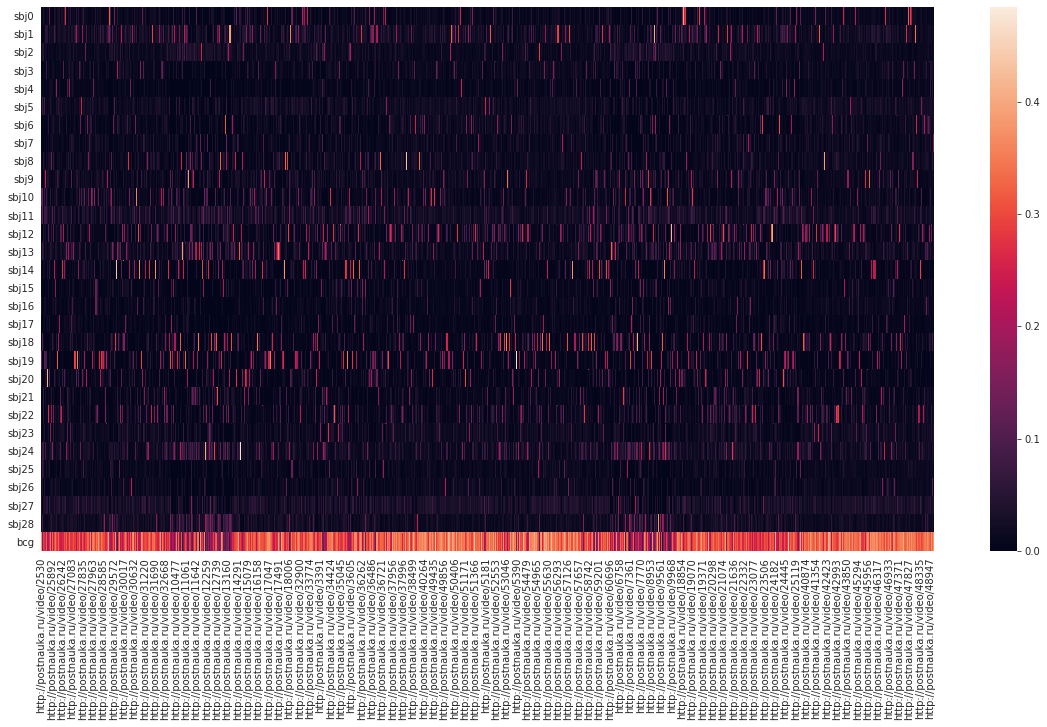

In [24]:
# Ваш код
fig = plt.figure(figsize=(20, 10))
seaborn.heatmap(theta[:100]);

Вы должны увидеть, что фоновая тема имеет большую вероятность в почти каждом документе, и это логично. Кроме того, есть еще одна тема, которая чаще других встречается в документах. Судя по всему, это тема содержит много слов по науку в целом, а каждый документ (видео) в нашей коллекции связан с наукой. Можно (необязательно) дать этой теме название "Наука".

Помимо этих двух тем, фоновой и общенаучной, каждый документ характеризуется малым числом других тем.

Оценим $p(t)$ - долю каждой темы во всей коллекции. По формуле полной вероятности вычислять эти величины нужно как
$p(t) = \sum_d p(t|d) p(d)$. Согласно вероятностной модели, $p(d)$ пропорционально длине документа d. Поступим проще: будем полагать, что все документы равновероятны. Тогда оценить $p(t)$ можно, просуммировав $p(t|d)$ по всем документам, а затем разделив полученный вектор на его сумму. 

Создайте переменную-датафрейм с T строками, индексированными названиями тем, и 1 столбцом, содержащим оценки $p(t)$. Выведите датафрейм на печать.

In [25]:
# Ваш код
n_columns = theta.shape[1]
pt = np.array([np.mean(theta.iloc[i]) for i in range(T)])
pt = pt.reshape((T, 1))

prob_theme = pd.DataFrame(data=pt, index=topic_labels, columns=['prob'])
prob_theme

,prob
теория,0.022166
при,0.040788
рассказывать,0.022081
понимать,0.016481
задача,0.011014
весь,0.020795
говорить,0.018248
человек,0.016437
кто,0.023691
проблема,0.025015


Визуализируйте матрицу $\Phi$ модальности авторов в виде изображения. Рекомендация: установите yticklabels=False в heatmap.

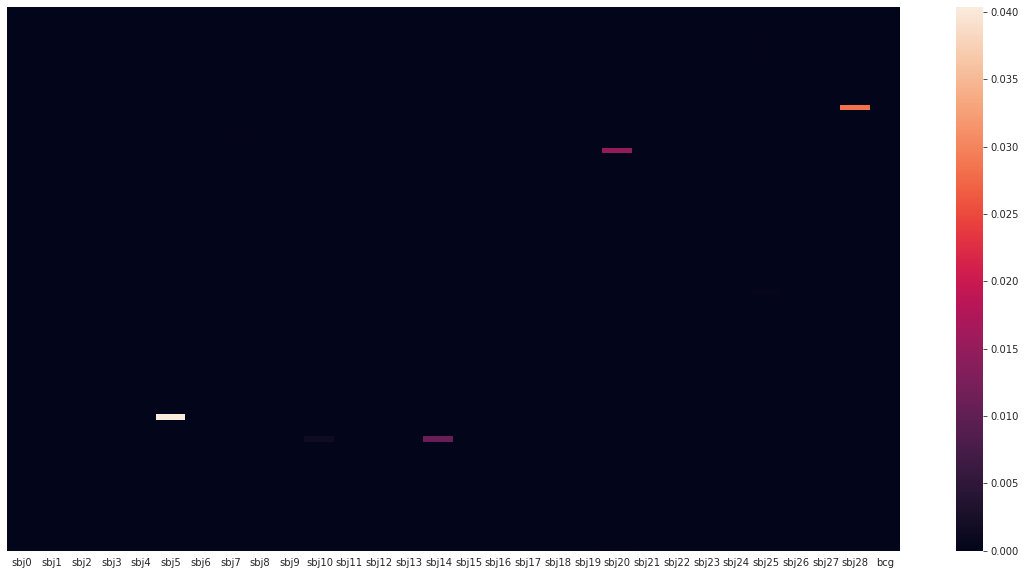

In [26]:
# Ваш код
fig = plt.figure(figsize=(20, 10))
seaborn.heatmap(phi_a[:100], yticklabels=False);

Каждой теме соответствует не очень большое число авторов - матрица достаточно разреженная. Кроме того, некоторые темы имеют доминирующего автора $a$, имеющего большую вероятность $p(a|t)$ - этот автор записал больше всего лекций по теме. 

Будем считать, что автор $a$ значим в теме, если $p(a|t) > 0.01$. Для каждого автора посчитайте, в скольких темах он значим. Найдите авторов-рекордсменов, которые значимы (а значит, читали лекции) в >= 3 темах.

Большинство авторов значимы в 1 теме, что логично.

##### Построение тематической карты авторов

По сути, в матрице $\Phi$, соответствующей модальности авторов, записаны тематические кластеры авторов. Для любого автора мы можем составить его тематический круг - авторов, разбирающихся в той же теме, что и данный. Интересующиеся слушатели могут попробовать выполнить эту процедуру для ученых, читающих лекции на Постнауке, которых они знают (например, на Постнауке есть лекции с К. В. Воронцовым - лектором текущего модуля :)

Составим карту близости авторов по тематике их исследований. Для этого применим метод понижения размерности MDS к тематическим профилям авторов.

Чтобы получить тематический профиль автора, распределение $p(t|a)$, нужно воспользоваться формулой Байеса: 
$p(t|a) = \frac {p(a|t) p(t)} {\sum_t' p(a|t') p(t')}$. Все необходимые для этого величины у вас есть и записаны в переменных phi и pt. 

Передайте матрицу тематических профилей авторов, записанных по строкам, в метод MDS с n_components=2. Используйте косинусную метрику (она хорошо подходит для поиска расстояний между векторами, имеющими фиксированную сумму компонент).

In [0]:
from sklearn.manifold import MDS
from sklearn.metrics import pairwise_distances

Визуализируйте найденные двумерные представления с помощью функции scatter. 

In [0]:
# Ваш код
prob_theme_author = np.empty(phi_a.shape)
for i in range(prob_theme_author.shape[0]):
    for j in range(prob_theme_author.shape[1]):
        prob_theme_author[i,j] = phi_a.iloc[i,j] * prob_theme.iloc[j,:] / np.sum(phi_a.iloc[i,:] * prob_theme.prob.values)

In [0]:
similarities = pairwise_distances(prob_theme_author, metric='cosine')
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
pos = mds.fit_transform(similarities)

In [0]:
plt.figure(figsize=(10,5))
plt.scatter(pos[:,0], pos[:,1])
plt.show();

# New Section

Должно получиться, что некоторые грппы авторов формируют сгустки, которые можно считать тематическими группами авторов.

Раскрасим точки следующим образом: для каждого автора выберем наиболее вероятную для него тему ($\max_t p(t|a)$), и каждой теме сопоставим цвет. Кроме того, добавим на карту имена и фамилии авторов, это можно сделать в цикле по всем точкам с помощью функции plt.annotate, указывая метку точки первым аргументом и ее координаты в аргументе xy. Рекомендуется сделать размер изображения большим, тогда маркеры точек тоже придется увеличить (s=100 в plt.scatter). Изобразите карту авторов и сохраните в pdf-файл с помощью функции plt.savefig. 

Метки авторов будут пересекаться. Будет очень хорошо, если вы найдете способ, как этого можно избежать.

In [0]:
import matplotlib.cm as cm
colors = cm.rainbow(np.linspace(0, 1, T)) # цвета для тем
# Ваш код

max_theme_prob_for_colors = [np.argmax(author) for author in prob_theme_author]
plt.figure(figsize=(15,10))
plt.axis('off')
plt.scatter(pos[:,0], pos[:,1], s=100, c=colors[max_theme_prob_for_colors])
for i, author in enumerate(phi_a.index):
        plt.annotate(author, pos[i])
plt.savefig('authors_map.pdf', dpi=200, format='pdf')
plt.show();

##### Создание простого тематического навигатора по Постнауке

Наш тематический навигатор будет для каждой темы показывать ее список слов, а также список релевантных теме документов. 

Нам понадобятся распределения $p(d|t)$. По формуле Байеса $p(d|t) = \frac{p(t|d)p(d)}{\sum_{d'}p(t|d')p(d')}$, но поскольку мы считаем документы равновероятными, достаточно разделить каждую строку $\Theta$ на ее сумму, чтобы оценить распределение. 

Отсортируйте матрицу $p(d|t)$ по убыванию $p(d|t)$ в каждой теме (то есть построчно). Нам понадобятся индексы наиболее вероятных документов в каждой теме, поэтому используйте функцию argmax.

In [0]:
# Ваш код
prob_doc_theme = theta.values / np.array([np.sum(theme) for theme in theta.values])[:, np.newaxis]
prob_doc_theme_sorted_indices = prob_doc_theme.argsort(axis=1)[:,::-1]
prob_doc_theme_sorted_indices

Создавать навигатор мы будем прямо в jupiter notebook: это возможно благодаря тому факту, что при печати ссылки она автоматически превращается в гиперссылку.

In [2]:
print("http://yandex.ru")   # получится кликабельная ссылка

http://yandex.ru


Кроме того, подключив модуль [ipython.core.display](https://ipython.org/ipython-doc/2/api/generated/IPython.core.display.html), можно использовать html-разметку в выводе. Например:

In [0]:
from IPython.core.display import display, HTML
display(HTML(u"<h1>Заголовок</h1>"))   # также <h2>, <h3>
display(HTML(u"<ul><li>Пункт 1</li><li>Пункт 2</li></ul>"))
display(HTML(u'<font color="green">Зеленый!</font>'))
display(HTML(u'<a href="http://yandex.ru">Еще один вариант вывода ссылки</a>'))

В цикле для каждой темы выведите ее заголовок, в следующей строке - топ-10 слов темы, затем в виде списка ссылки на 10 наиболее релевантных (по $p(d|t)$) теме документов. Используйте html-разметку. Творчество приветствуется :)

In [0]:
# Ваш код
for i, theme in enumerate(topic_labels):
    display(HTML("<h3>%s</h3>" % theme))
    for j in range(10):
        print(tokens[model.topic_names[i]][j]),
    print('')
    for k in range(10):
        print(theta.columns[prob_doc_theme_sorted_indices[i,k]])

##### Заключение

В этом Peer Review мы познакомились с базовыми возможностями библиотеки BigARTM и с методами визуализации тематических моделей. Визуализация тематических моделей - это широкая и активно развивающаяся область научных исследований. Мы рассмотрели только самые простые приемы. Желающие могут попробовать применить [Serendip](http://vep.cs.wisc.edu/serendip/#serendipHero), разработанный в  University of Wisconsin-Madison, к построенной модели. Эта библиотека позволяет максимально полно охарактеризовать темы и написана для языка python. 

Сделав задание, вы можете выбрать в навигаторе наиболее интересную для вас тему и посмотреть видеолекции :) На Постнауке очень много интересных материалов. 